In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# First: Loading, Joining, Melting, Casting

The data seems to be collected over the course of a few days, assuming time affects everything equally such that emails are fairly distributed across them similarly, we can first reduce on it, keeping in mind that the data is summed over the course of 5 days.

Also. Seems that the distribution of total emails sent and received per person is roughly normally distributed. With perhaps BCC being more skewed as few people use more of it than most.

When seperated by exchanges however, email distribution are fairly skewed. Number of people sent and received by anyone to and from a given person drops off sharply with email counts. Between two teams, there are a few people exchanging a lot of emails while most exchanges just a few. This warrants some caution and we'll probably use median as a measure of central tendency as opposed to the mean.

In [2]:
filename = "Humanyze_Internal_Dataset_email.xlsx"
sheet1name = "ParticipantInfo"
sheet2name = "Daily E-mail"
infodf = pd.read_excel(filename, sheet1name)
emaildf = pd.read_excel(filename, sheet2name)
#infodf.info()
#emaildf.info()

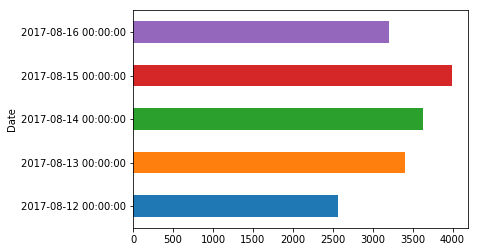

In [3]:
emaildf.groupby(by="Date").sum().Count.plot.barh()

In [4]:
type_df = pd.pivot_table(emaildf, values='Count', index = emaildf.index, columns=['Receiver type'])
type_df.fillna(0, inplace=True)
type_df = pd.merge(emaildf, type_df, how="left", left_index = True, right_index = True)
type_df = type_df.rename(columns={'Count': 'Total'})

In [5]:
timesum_df = type_df.groupby(by=["Sender","Receiver"], as_index=False).sum()

In [6]:
df = pd.merge(timesum_df, infodf, how="left", left_on="Sender", right_on="UserID", copy = False)
df = pd.merge(df, infodf, how="left", left_on="Receiver", right_on="UserID", suffixes=["_S","_R"])
df = df.drop(["UserID_S", "UserID_R"], axis=1)

In [7]:
for suffix in ['_S','_R']:
    df["LocTeam"+suffix] = df[['Location'+suffix,'Team'+suffix]].apply(lambda x: ' '.join(x),axis=1)

In [8]:
columns = ['Total','TO','BCC','CC']

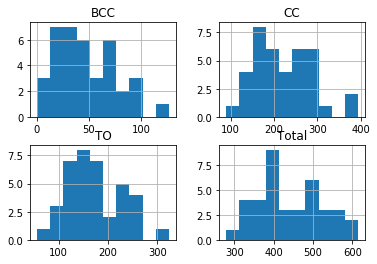

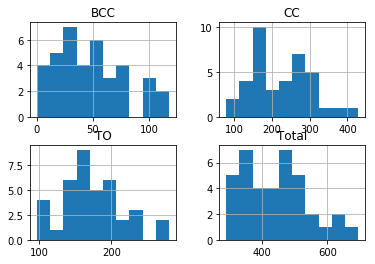

In [9]:
send_pax_sum = df.groupby(by="Sender").sum().hist(column=columns)
#df.groupby(by="Sender").median().hist(column=columns)
receive_pax_sum = df.groupby(by="Receiver").sum().hist(column=columns)
#df.groupby(by="Sender").median().hist(column=columns)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106d8a150>,
      dtype=object)

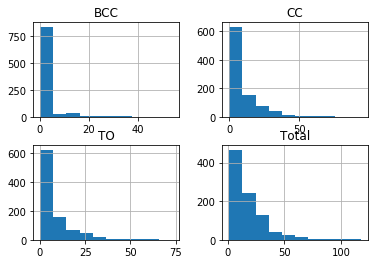

In [10]:
df[columns].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106fa4d50>,
      dtype=object)

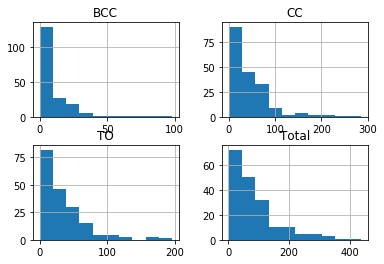

In [11]:
interteam_sum_df = df.groupby(by=["LocTeam_S","LocTeam_R","Sender"], as_index=False).sum()
interteam_sum_df.hist(column=columns)
#interteam_pax_df = interteam_sum_df.groupby(by=["LocTeam_S","LocTeam_R"], as_index=False).median()

# Cohesion
More emails sent between the Boston than PA location?

,Total,TO,BCC,CC
Boston,380.5,127.5,36.0,168.5
Palo Alto,255.0,112.5,25.0,99.5


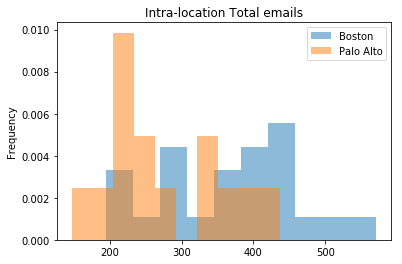

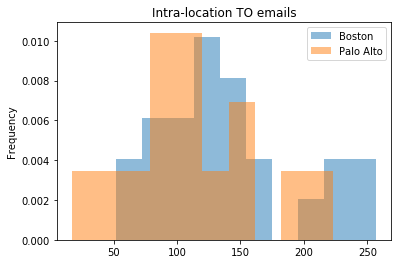

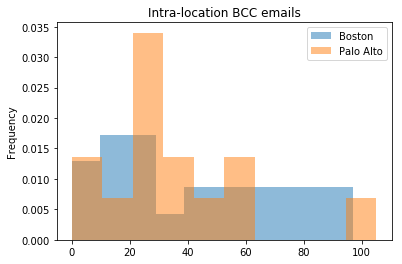

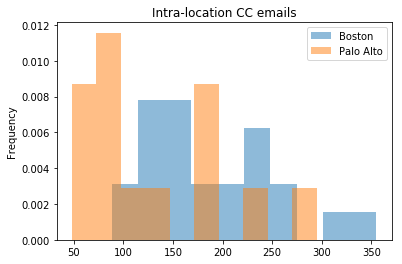

In [12]:
byloc_df = pd.pivot_table(df, values=columns, index=['Location_S','Sender'], columns=['Location_R'], aggfunc=np.sum)
intraloc_med_df = pd.DataFrame()
for column in columns:
    plt.figure()
    for loca in ['Boston','Palo Alto']:
        sub_df = byloc_df[column].loc[loca,loca]
        sub_df.plot.hist(alpha=0.5,legend=['Boston','Palo Alto'],title='Intra-location '+column+' emails',density=True)
        intraloc_med_df.loc[loca,column] = sub_df.median()
intraloc_med_df

# Manager Visibility
more emails to and from corresponding team managers at Boston than at PA?

In [13]:
summary_df = pd.DataFrame()
localcounts_df = pd.DataFrame()
for suffix in ['_S','_R']:
    managers_df = df[(df['Manager?'+suffix]=='Y') & (df.LocTeam_S==df.LocTeam_R)]
    counts_df = managers_df.groupby(by=['Location'+suffix])['Sender','Receiver'].nunique()
    counts_df['Manager Sending/Receiving?'] = suffix
    localcounts_df = localcounts_df.append(counts_df)
    managers_df = managers_df.groupby(by=['Location'+suffix,'Sender']).sum()
    median_df = managers_df[columns].groupby(by=['Location'+suffix]).median()
    median_df['Manager Sending/Receiving?'] = suffix
    summary_df = summary_df.append(median_df)
allcounts_df = df.groupby('Location_S')['Sender','Receiver'].nunique()
summary_df

,Total,TO,BCC,CC,Manager Sending/Receiving?
Boston,191.5,89.5,9.5,63.0,_S
Palo Alto,217.0,76.0,12.0,91.0,_S
Boston,49.0,21.0,0.0,18.0,_R
Palo Alto,85.0,25.0,0.0,49.0,_R


# Visualizing Email Exchanges
I found no easy way to satifactorily produce chord diagrams in Python. But to keep it all in the notebook, I modified [a Github repo](https://github.com/fengwangPhysics/matplotlib-chord-diagram) that does fairly well.

In [14]:
###################
# chord diagram adapted from https://github.com/fengwangPhysics/matplotlib-chord-diagram
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import numpy as np

LW = 0.3

def polar2xy(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def hex2rgb(c):
    return tuple(int(c[i:i+2], 16)/256.0 for i in (1, 3 ,5))

def IdeogramArc(start=0, end=60, radius=1.0, width=0.2, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    # optimal distance to the control points
    # https://stackoverflow.com/questions/1734745/how-to-create-circle-with-b%C3%A9zier-curves
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    inner = radius*(1-width)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(inner, end),
        polar2xy(inner, end) + polar2xy(opt*(1-width), end-0.5*np.pi),
        polar2xy(inner, start) + polar2xy(opt*(1-width), start+0.5*np.pi),
        polar2xy(inner, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.LINETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CLOSEPOLY,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)


def ChordArc(start1=0, end1=60, start2=180, end2=240, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start1 > end1:
        start1, end1 = end1, start1
    if start2 > end2:
        start2, end2 = end2, start2
    start1 *= np.pi/180.
    end1 *= np.pi/180.
    start2 *= np.pi/180.
    end2 *= np.pi/180.
    opt1 = 4./3. * np.tan((end1-start1)/ 4.) * radius
    opt2 = 4./3. * np.tan((end2-start2)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start1),
        polar2xy(radius, start1) + polar2xy(opt1, start1+0.5*np.pi),
        polar2xy(radius, end1) + polar2xy(opt1, end1-0.5*np.pi),
        polar2xy(radius, end1),
        polar2xy(rchord, end1),
        polar2xy(rchord, start2),
        polar2xy(radius, start2),
        polar2xy(radius, start2) + polar2xy(opt2, start2+0.5*np.pi),
        polar2xy(radius, end2) + polar2xy(opt2, end2-0.5*np.pi),
        polar2xy(radius, end2),
        polar2xy(rchord, end2),
        polar2xy(rchord, start1),
        polar2xy(radius, start1),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def selfChordArc(start=0, end=60, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(rchord, end),
        polar2xy(rchord, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def chordDiagram(X, ax, colors=None, width=0.1, pad=2, chordwidth=0.7):
    """Plot a chord diagram

    Parameters
    ----------
    X :
        flux data, X[i, j] is the flux from i to j
    ax :
        matplotlib `axes` to show the plot
    colors : optional
        user defined colors in rgb format. Use function hex2rgb() to convert hex color to rgb color. Default: d3.js category10
    width : optional
        width/thickness of the ideogram arc
    pad : optional
        gap pad between two neighboring ideogram arcs, unit: degree, default: 2 degree
    chordwidth : optional
        position of the control points for the chords, controlling the shape of the chords
    """
    # X[i, j]:  i -> j
    x = X.sum(axis = 1) # sum over rows
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    if colors is None:
    # use d3.js category10 https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        if len(x) > 10:
            print('x is too large! Use x smaller than 10')
        colors = [hex2rgb(colors[i]) for i in range(len(x))]

    # find position for each start and end
    y = x/np.sum(x).astype(float) * (360 - pad*len(x))

    pos = {}
    arc = []
    nodePos = []
    start = 0
    for i in range(len(x)):
        end = start + y[i]
        arc.append((start, end))
        angle = 0.5*(start+end)
        #print(start, end, angle)
        if -30 <= angle <= 210:
            angle -= 90
        else:
            angle -= 270
        nodePos.append(tuple(polar2xy(1.1, 0.5*(start+end)*np.pi/180.)) + (angle,))
        z = (X[i, :]/x[i].astype(float)) * (end - start)
        ids = np.argsort(z)
        z0 = start
        for j in ids:
            pos[(i, j)] = (z0, z0+z[j])
            z0 += z[j]
        start = end + pad

    for i in range(len(x)):
        start, end = arc[i]
        IdeogramArc(start=start, end=end, radius=1.0, ax=ax, color=colors[i], width=width)
        start, end = pos[(i,i)]
        selfChordArc(start, end, radius=1.-width, color=colors[i], chordwidth=chordwidth*0.7, ax=ax)
        for j in range(i):
            color = colors[i]
            if X[i, j] < X[j, i]:
                color = colors[j]
            else:
                color = colors[i]
            start1, end1 = pos[(i,j)]
            start2, end2 = pos[(j,i)]
            ChordArc(start1, end1, start2, end2,
                     radius=1.-width, color=color, chordwidth=chordwidth, ax=ax)

    #print(nodePos)
    return nodePos

In [15]:
pivot_table = pd.pivot_table(df, values=columns, index=['LocTeam_S',"Sender"], columns=['LocTeam_R'],aggfunc=np.sum)
#pivot_table.hist()
interteam_med_df = pivot_table.groupby(by="LocTeam_S").median()

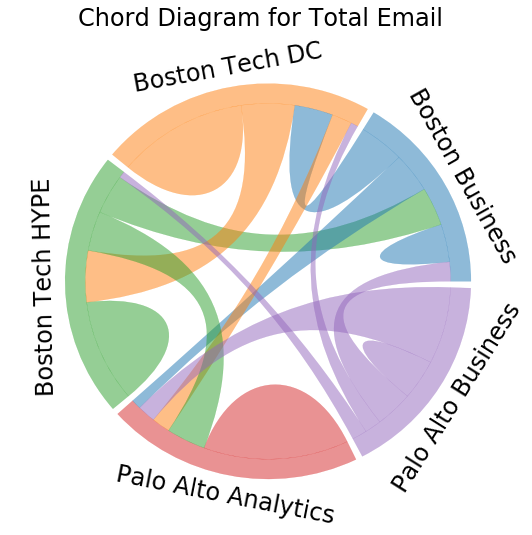

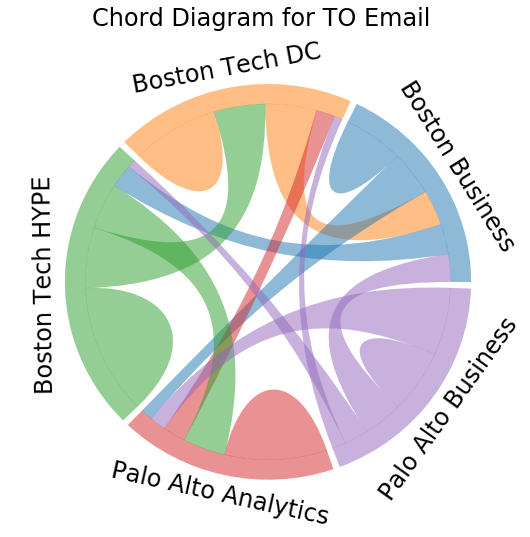

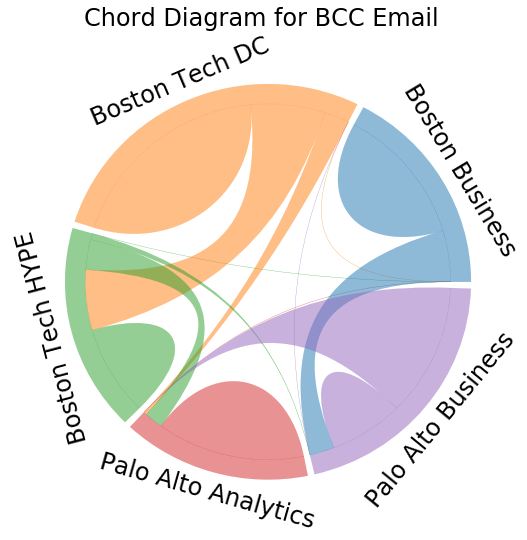

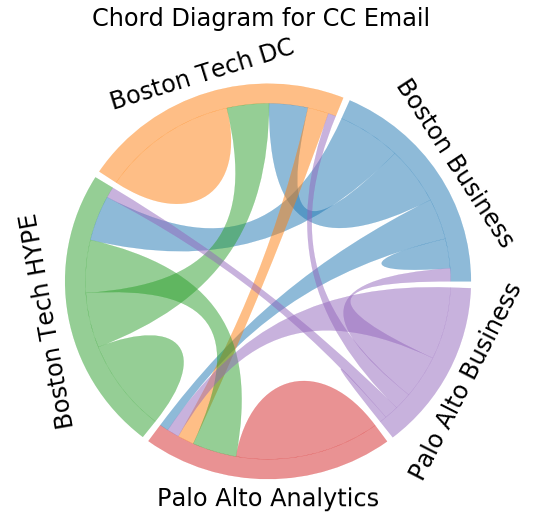

In [16]:
for column in columns:
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Chord Diagram for '+column+' Email',fontsize=24)
    ax = plt.axes()
    nodePos = chordDiagram(interteam_med_df[column].as_matrix(),ax)
    ax.axis('off')
    prop = dict(fontsize=24, ha='center', va='center')
    nodes = interteam_med_df[column].columns
    for i in range(len(nodes)):
        ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][2], **prop)
    plt.savefig(column + " chord.png", dpi=600,
                transparent=True, bbox_inches='tight', pad_inches=0.02)

# 4 part 1

On average, how much does an individual email someone at their own site over the other site

In [17]:
for column in columns:
    sub_df = byloc_df[column]
    byloc_df["locdiff_"+column] = np.where(
        sub_df.index.get_level_values("Location_S") == "Boston", sub_df["Boston"].values - sub_df["Palo Alto"].values, -sub_df[
        "Boston"].values + sub_df["Palo Alto"].values)
    #plt.figure()
    #byloc_df["locdiff_"+column].hist()
byloc_df.mean().to_frame()

0
              Location_R            
BCC           Boston       29.815789
              Palo Alto    17.578947
CC            Boston      142.921053
              Palo Alto    77.710526
TO            Boston      110.789474
              Palo Alto    63.263158
Total         Boston      283.526316
              Palo Alto   158.552632
locdiff_Total             228.289474
locdiff_TO                 85.157895
locdiff_BCC                30.342105
locdiff_CC                112.789474

# 4 Part 2
Most and least intra-team emails

,Total,TO,BCC,CC
LocTeam_S,,,,
Boston Business,76.5,44.5,23.0,27.5
Boston Tech DC,258.0,65.0,34.0,123.0
Boston Tech HYPE,207.0,99.0,15.0,86.0
Palo Alto Analytics,286.5,76.0,24.0,131.0
Palo Alto Business,81.5,48.0,12.0,6.5


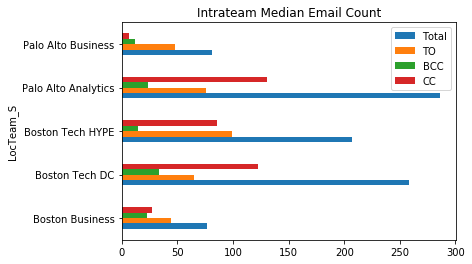

In [18]:
intrateam_df = pd.DataFrame(index=interteam_med_df.index)
for column in columns:
    intrateam_df[column] = pd.Series(np.diag(interteam_med_df[column]), index=[
        interteam_med_df.index, interteam_med_df[column].columns]).values
intrateam_df.plot.barh(title="Intrateam Median Email Count")
intrateam_df